In [1]:
from pathlib import Path
from itertools import combinations
import warnings

warnings.filterwarnings("ignore")
import sys
print(sys.executable)
print('\n'.join(sys.path))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score, pairwise_distances, accuracy_score
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
from Annotatability import models
from Annotatability import metrics
import scvi
import logging
import squidpy as sq
import contextlib
import io
import random
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # Added imports
import scipy.sparse as sp
from sklearn.model_selection import train_test_split

logging.getLogger("scvi").setLevel(logging.WARNING)

SMALL_SIZE = 16
MEDIUM_SIZE = 20.5
BIGGER_SIZE = 24
#plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sc.set_figure_params(scanpy=True, fontsize=20.5)

# Define custom color palette
annotation_order = ['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']
annotation_colors = ['green', 'orange', 'red']
palette = dict(zip(annotation_order, annotation_colors))

/Users/idansegal/Documents/Coding/Annotatability_transfer/new_clean_env/bin/python
/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload

/Users/idansegal/Documents/Coding/Annotatability_transfer/new_clean_env/lib/python3.9/site-packages


In [2]:
from pathlib import Path
from itertools import combinations
import warnings

warnings.filterwarnings("ignore")
import sys
print(sys.executable)
print('\n'.join(sys.path))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score, pairwise_distances, accuracy_score
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
from Annotatability import models
from Annotatability import metrics
import scvi
import logging
import squidpy as sq
import contextlib
import io
import random
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # Added imports
import scipy.sparse as sp
from sklearn.model_selection import train_test_split

logging.getLogger("scvi").setLevel(logging.WARNING)

SMALL_SIZE = 16
MEDIUM_SIZE = 20.5
BIGGER_SIZE = 24
#plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sc.set_figure_params(scanpy=True, fontsize=20.5)

# Define custom color palette
annotation_order = ['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']
annotation_colors = ['green', 'orange', 'red']
palette = dict(zip(annotation_order, annotation_colors))

/Users/idansegal/Documents/Coding/Annotatability_transfer/new_clean_env/bin/python
/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload

/Users/idansegal/Documents/Coding/Annotatability_transfer/new_clean_env/lib/python3.9/site-packages


In [3]:
from tqdm import tqdm
import contextlib
import io

# Initialize StringIO object to suppress outputs
f = io.StringIO()

def train_and_get_prob_list(adata, label_key, epoch_num, device=device, batch_size=128):
    print('Training the model...')
    with contextlib.redirect_stdout(f):
        prob_list = models.follow_training_dyn_neural_net(
            adata,
            label_key=label_key,
            iterNum=epoch_num,
            device=device,
            batch_size=batch_size
        )
    print('Training complete.')
    return prob_list

def calculate_confidence_and_variability(prob_list, n_obs, epoch_num):
    with contextlib.redirect_stdout(f):
        all_conf, all_var = models.probability_list_to_confidence_and_var(
            prob_list,
            n_obs=n_obs,
            epoch_num=epoch_num
        )
    return all_conf, all_var

def find_cutoffs(adata, label_key, device, probability, percentile, epoch_num):
    with contextlib.redirect_stdout(f):
        cutoff_conf, cutoff_var = models.find_cutoff_paramter(
            adata,
            label_key,
            device,
            probability=probability,
            percentile=percentile,
            epoch_num=epoch_num
        )
    return cutoff_conf, cutoff_var

def assign_annotations(adata, all_conf, all_var, cutoff_conf, cutoff_var, annotation_col='Annotation'):
    adata.obs["var"] = all_var.detach().numpy()
    adata.obs["conf"] = all_conf.detach().numpy()
    adata.obs['conf_binaries'] = pd.Categorical(
        (adata.obs['conf'] > cutoff_conf) | (adata.obs['var'] > cutoff_var)
    )

    annotation_list = []
    for i in tqdm(range(adata.n_obs), desc='Assigning annotations'):
        if adata.obs['conf_binaries'].iloc[i]:
            if (adata.obs['conf'].iloc[i] > 0.95) & (adata.obs['var'].iloc[i] < 0.15):
                annotation_list.append('Easy-to-learn')
            else:
                annotation_list.append('Ambiguous')
        else:
            annotation_list.append('Hard-to-learn')

    adata.obs[annotation_col] = annotation_list
    adata.obs['Confidence'] = adata.obs['conf']
    adata.obs['Variability'] = adata.obs['var']
    return adata

# Preprocess Merfish and PBMC

In [4]:
# Load and preprocess the data
adata_merfish = sq.datasets.merfish()
sc.pp.normalize_per_cell(adata_merfish, counts_per_cell_after=1e4)
sc.pp.log1p(adata_merfish)

# Map clusters to cell types
cell_type_mapping = {
    'OD Mature 2': 'OD Mature',
    'OD Immature 1': 'OD Immature',
    'Inhibitory': 'Inhibitory',
    'Excitatory': 'Excitatory',
    'Microglia': 'Microglia',
    'Astrocyte': 'Astrocyte',
    'Endothelial 2': 'Endothelial',
    'Endothelial 3': 'Endothelial',
    'Endothelial 1': 'Endothelial',
    'OD Mature 1': 'OD Mature',
    'OD Mature 4': 'OD Mature',
    'Pericytes': 'Pericytes',
    'OD Mature 3': 'OD Mature',
    'Ependymal': 'Ependymal',
    'OD Immature 2': 'OD Immature'
}
adata_merfish.obs['CellType'] = adata_merfish.obs['Cell_class'].map(cell_type_mapping).fillna(adata_merfish.obs['Cell_class'])

In [ ]:
# Load the dataset
# PBMC full is obtained from https://cellxgene.cziscience.com/collections/03f821b4-87be-4ff4-b65a-b5fc00061da7
# Change to your path below
adata_full = sc.read_h5ad('PBMC_full.h5ad')

# Filter to include only healthy cells
# Assuming that 'condition' is a column in adata_full.obs indicating health status
# Adjust 'Healthy' to match the actual label used in your dataset
adata_healthy = adata_full[adata_full.obs['condition'] == 'Healthy'].copy()

# Inspect the cell types available
print("Available cell types in the healthy dataset:")
print(adata_healthy.obs['cell_type'].unique())

# Define the list of cell types to keep
# Update this list based on the cell types present in your dataset
cell_types_to_keep = [
    'B cells',
    'CD4 T cells',
    'CD8 T cells',
    'CD14+ Monocytes',
    'Dendritic Cells',
    'FCGR3A+ Monocytes',
    'NK cells'
]

# Filter the data to include only the selected cell types
adata_healthy = adata_healthy[adata_healthy.obs['cell_type'].isin(cell_types_to_keep)].copy()

# Normalize and log-transform the data
sc.pp.normalize_total(adata_healthy, target_sum=1e4)
sc.pp.log1p(adata_healthy)

pbmc = adata_healthy

In [ ]:
print("MERFISH")
prob_list_merfish = train_and_get_prob_list(adata_merfish, label_key='CellType', epoch_num=150, device=device, batch_size=64)

# Train and get confidence and variability of MERFISH
all_conf_merfish, all_var_merfish = calculate_confidence_and_variability(prob_list_merfish, n_obs=adata_merfish.n_obs, epoch_num=150)

# Find cutoffs of MERFISH
conf_cutoff_merfish, var_cutoff_merfish = find_cutoffs(adata_merfish, 'CellType', device, probability=0.1, percentile=90, epoch_num=150)

# Assign annotations
adata_merfish = assign_annotations(adata_merfish, all_conf_merfish, all_var_merfish, conf_cutoff_merfish, var_cutoff_merfish, annotation_col='Annotation')

# Count the number of cells in each group
group_counts_merfish = adata_merfish.obs['Annotation'].value_counts()

print(group_counts_merfish)

Training the model...
Training complete.


Assigning annotations: 100%|██████████| 73642/73642 [00:01<00:00, 46585.77it/s]

Annotation
Ambiguous        38974
Easy-to-learn    31036
Hard-to-learn     3632
Name: count, dtype: int64


In [ ]:
print("PBMC")
# Train the model and get probability list for PBMC dataset
prob_list_pbmc = train_and_get_prob_list(pbmc, label_key='cell_type', epoch_num=150, device=device, batch_size=64)

# Calculate confidence and variability for PBMC
all_conf_pbmc, all_var_pbmc = calculate_confidence_and_variability(prob_list_pbmc, n_obs=pbmc.n_obs, epoch_num=150)

# Find cutoffs for PBMC
conf_cutoff_pbmc, var_cutoff_pbmc = find_cutoffs(pbmc, 'cell_type', device, probability=0.1, percentile=90, epoch_num=150)

# Assign annotations
pbmc = assign_annotations(pbmc, all_conf_pbmc, all_var_pbmc, conf_cutoff_pbmc, var_cutoff_pbmc, annotation_col='Annotation')

# Count the number of cells in each group
group_counts_pbmc = pbmc.obs['Annotation'].value_counts()

print(group_counts_pbmc)

In [ ]:
# Assuming 'group_counts_merfish' is a pandas Series with annotations as indices
group_counts_merfish = adata_merfish.obs['Annotation'].value_counts()

# Assign counts to E_merfish, A_merfish, H_merfish
E_merfish = group_counts_merfish.get('Easy-to-learn', 0)
A_merfish = group_counts_merfish.get('Ambiguous', 0)
H_merfish = group_counts_merfish.get('Hard-to-learn', 0)

# Get the indices of each group
easy_indices_merfish = adata_merfish.obs.index[adata_merfish.obs['Annotation'] == 'Easy-to-learn'].tolist()
ambiguous_indices_merfish = adata_merfish.obs.index[adata_merfish.obs['Annotation'] == 'Ambiguous'].tolist()
hard_indices_merfish = adata_merfish.obs.index[adata_merfish.obs['Annotation'] == 'Hard-to-learn'].tolist()

# Fit LabelEncoder on the entire dataset labels
global_label_encoder_merfish = LabelEncoder()
global_label_encoder_merfish.fit(adata_merfish.obs['CellType'])
num_classes_merfish = len(global_label_encoder_merfish.classes_)

# Verify the counts match E_merfish, A_merfish, H_merfish
print("MERFISH:")
print(f"Number of Easy-to-learn samples: {len(easy_indices_merfish)}")
print(f"Number of Ambiguous samples: {len(ambiguous_indices_merfish)}")
print(f"Number of Hard-to-learn samples: {len(hard_indices_merfish)}")

Number of Easy-to-learn samples: 31036
Number of Ambiguous samples: 38974
Number of Hard-to-learn samples: 3632


In [ ]:
# Assuming 'group_counts_pbmc' is a pandas Series with annotations as indices
group_counts_pbmc = pbmc.obs['Annotation'].value_counts()

# Assign counts to E_pbmc, A_pbmc, H_pbmc
E_pbmc = group_counts_pbmc.get('Easy-to-learn', 0)
A_pbmc = group_counts_pbmc.get('Ambiguous', 0)
H_pbmc = group_counts_pbmc.get('Hard-to-learn', 0)

# Get the indices of each group
easy_indices_pbmc = pbmc.obs.index[pbmc.obs['Annotation'] == 'Easy-to-learn'].tolist()
ambiguous_indices_pbmc = pbmc.obs.index[pbmc.obs['Annotation'] == 'Ambiguous'].tolist()
hard_indices_pbmc = pbmc.obs.index[pbmc.obs['Annotation'] == 'Hard-to-learn'].tolist()

# Fit LabelEncoder on the entire dataset labels
global_label_encoder_pbmc = LabelEncoder()
global_label_encoder_pbmc.fit(pbmc.obs['cell_type'])
num_classes_pbmc = len(global_label_encoder_pbmc.classes_)

# Verify the counts match E_pbmc, A_pbmc, H_pbmc
print("PBMC:")
print(f"Number of Easy-to-learn samples: {len(easy_indices_pbmc)}")
print(f"Number of Ambiguous samples: {len(ambiguous_indices_pbmc)}")
print(f"Number of Hard-to-learn samples: {len(hard_indices_pbmc)}")

In [ ]:
class BaseNet(nn.Module):
    def __init__(self, layer_sizes):
        super(BaseNet, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return torch.log_softmax(x, dim=1)

class Net(BaseNet):
    def __init__(self, input_size, output_size):
        layer_sizes = [input_size, int(input_size / 2), int(input_size / 4), output_size]
        super(Net, self).__init__(layer_sizes)

def one_hot_encode(labels, label_encoder):
    values = np.array(labels)
    integer_encoded = label_encoder.transform(values)
    onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

def is_scipy_cs_sparse(matrix):
    return sp.issparse(matrix) and matrix.getformat() == 'csr'

def train_and_evaluate_model(
    adata_train, 
    adata_test, 
    label_key, 
    label_encoder, 
    num_classes,      
    epoch_num, 
    device,         
    batch_size=128
):
    """
    Trains and evaluates a neural network model on the provided training and testing data.
    
    Parameters:
    - adata_train (AnnData): Training dataset.
    - adata_test (AnnData): Testing dataset.
    - label_key (str): Key in adata.obs that contains the labels.
    - label_encoder (LabelEncoder): Fitted LabelEncoder instance.
    - num_classes (int): Number of unique classes in the dataset.
    - epoch_num (int): Number of training epochs.
    - device (str or torch.device): Device to run the training on ('cpu' or 'cuda').
    - batch_size (int): Batch size for training.
    
    Returns:
    - test_loss (float): Loss on the test dataset.
    """
    def one_hot_encode(labels, label_encoder):
        values = np.array(labels)
        integer_encoded = label_encoder.transform(values)
        onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        return onehot_encoded

    def is_scipy_cs_sparse(matrix):
        return sp.issparse(matrix) and matrix.getformat() == 'csr'
    
    # Encode labels using the provided label encoder
    one_hot_label_train = one_hot_encode(adata_train.obs[label_key], label_encoder=label_encoder)
    one_hot_label_test = one_hot_encode(adata_test.obs[label_key], label_encoder=label_encoder)

    # Initialize the neural network
    net = Net(adata_train.X.shape[1], output_size=num_classes)
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    # Prepare training data
    if is_scipy_cs_sparse(adata_train.X):
        x_train = adata_train.X.toarray()
    else:
        x_train = np.array(adata_train.X)
    tensor_x_train = torch.Tensor(x_train).to(device)
    tensor_y_train = torch.LongTensor(np.argmax(one_hot_label_train, axis=1)).to(device)
    train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Prepare test data
    if is_scipy_cs_sparse(adata_test.X):
        x_test = adata_test.X.toarray()
    else:
        x_test = np.array(adata_test.X)
    tensor_x_test = torch.Tensor(x_test).to(device)
    tensor_y_test = torch.LongTensor(np.argmax(one_hot_label_test, axis=1)).to(device)

    # Train the network
    net.train()
    for epoch in range(epoch_num):
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on test set
    net.eval()
    with torch.no_grad():
        outputs = net(tensor_x_test)
        test_loss = criterion(outputs, tensor_y_test).item()

    return test_loss

In [ ]:
import random
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

def run_experiment(
    dataset_name,
    adata,
    label_key,
    group_counts,
    easy_indices,
    ambiguous_indices,
    hard_indices,
    label_encoder,
    num_classes,
    train_sizes,
    repeats_per_size,
    csv_file,
    device,
    epoch_num=30,
    batch_size=64
):
    """
    Runs the training and evaluation experiment for a given dataset.

    Parameters:
    - dataset_name (str): Name identifier for the dataset (e.g., 'merfish', 'pbmc').
    - adata (AnnData): The dataset to process.
    - label_key (str): The key in adata.obs that contains the labels.
    - group_counts (dict): Dictionary containing counts for 'Easy-to-learn', 'Ambiguous', 'Hard-to-learn'.
    - easy_indices (list): List of indices for 'Easy-to-learn' samples.
    - ambiguous_indices (list): List of indices for 'Ambiguous' samples.
    - hard_indices (list): List of indices for 'Hard-to-learn' samples.
    - label_encoder (LabelEncoder): Fitted LabelEncoder instance.
    - num_classes (int): Number of unique classes in the dataset.
    - train_sizes (list of int): List of training set sizes to experiment with.
    - repeats_per_size (int): Number of repeats for each training size.
    - csv_file (str): Filename to save/load the results.
    - device (torch.device): The device to run the training on ('cpu' or 'cuda').
    - epoch_num (int): Number of training epochs.
    - batch_size (int): Batch size for training.

    Returns:
    - best_compositions (dict): Dictionary containing the best compositions and their corresponding test losses.
    """
    # Load existing results from CSV or create an empty DataFrame
    try:
        results_df = pd.read_csv(csv_file)
    except FileNotFoundError:
        # Include 'Train_Indices' and 'Test_Indices' columns
        results_df = pd.DataFrame(columns=['Train_Size', 'Easy', 'Ambiguous', 'Hard', 'Test_Loss', 'Train_Indices', 'Test_Indices'])

    # Convert the 'Train_Size' column to a dictionary with counts for faster lookup
    existing_counts = results_df['Train_Size'].value_counts().to_dict()

    best_compositions = {}

    for T in train_sizes:
        current_runs = existing_counts.get(T, 0)
        runs_needed = repeats_per_size - current_runs

        if runs_needed <= 0:
            # Use existing entries
            existing_rows = results_df[results_df['Train_Size'] == T]
            for idx, row in existing_rows.iterrows():
                easy = row['Easy']
                ambiguous = row['Ambiguous']
                hard = row['Hard']
                test_loss = row['Test_Loss']
                train_indices_str = row.get('Train_Indices', None)
                test_indices_str = row.get('Test_Indices', None)
                print(
                    f"Using cached result for {dataset_name} Train_Size={T}: Easy={easy}, Ambiguous={ambiguous}, Hard={hard}, Test Loss={test_loss}"
                )
                # Store the cached results
                if T not in best_compositions:
                    best_compositions[T] = []
                best_compositions[T].append({
                    'composition': (easy, ambiguous, hard),
                    'Test_Loss': test_loss,
                    'Train_Indices': train_indices_str,
                    'Test_Indices': test_indices_str
                })
            continue  # Skip computation for this T as all repeats are already done

        else:
            print(f"\nProcessing {dataset_name} train dataset size: {T} (Run {current_runs + 1} to {repeats_per_size})")

            # Calculate test size (25% of train size)
            test_size = int(0.25 * T)
            total_size = T + test_size
            print(f"Total dataset size (Train + Test): {total_size} (Train: {T}, Test: {test_size})")

            # Select the test indices once per dataset size
            all_indices = adata.obs.index.tolist()
            # Ensure we have enough samples for test set
            if len(all_indices) < test_size:
                print(f"Not enough samples for Test Size={test_size} at Train_Size={T}")
                continue  # Skip if not enough samples

            # Randomly sample test_size samples for the test set
            test_indices = random.sample(all_indices, test_size)

            # Remaining indices after selecting the test set
            remaining_indices = list(set(all_indices) - set(test_indices))

            # Define step size as a function of T
            step_size = max(1, T // 100)

            # Generate compositions summing up to T (train size)
            compositions = []
            E = group_counts.get('Easy-to-learn', 0)
            A = group_counts.get('Ambiguous', 0)
            H = group_counts.get('Hard-to-learn', 0)
            for e in range(0, min(T, E) + 1, step_size):
                for a in range(0, min(T - e, A) + 1, step_size):
                    h = T - e - a
                    if h >= 0 and h <= H:
                        compositions.append((e, a, h))
            if not compositions:
                print(f"No valid compositions for Train Size={T}")
                # Save an entry indicating no valid compositions
                new_row = {
                    'Train_Size': T,
                    'Easy': None,
                    'Ambiguous': None,
                    'Hard': None,
                    'Test_Loss': None,
                    'Train_Indices': None,
                    'Test_Indices': ','.join(map(str, test_indices))
                }
                new_row_df = pd.DataFrame([new_row])
                results_df = pd.concat([results_df, new_row_df], ignore_index=True)
                results_df.to_csv(csv_file, index=False)
                continue

            print(f"Total compositions for Train Size={T}: {len(compositions)}")

            for run in range(current_runs + 1, repeats_per_size + 1):
                print(f"\n--- Run {run} for Train_Size={T} ---")

                min_loss = float('inf')
                best_comp = None
                best_train_indices = None

                # For each composition, train and get test loss
                for comp in tqdm(compositions, desc=f"Testing compositions for Train Size={T} - Run {run}"):
                    e, a, h = comp
                    # Ensure not exceeding group counts
                    if e > E or a > A or h > H:
                        continue  # Invalid composition

                    # Ensure we have enough samples in each group
                    if len(easy_indices) < e or len(ambiguous_indices) < a or len(hard_indices) < h:
                        continue  # Skip if not enough samples

                    # Randomly sample e, a, h samples from each group for training
                    available_easy = list(set(easy_indices) - set(test_indices))
                    available_ambiguous = list(set(ambiguous_indices) - set(test_indices))
                    available_hard = list(set(hard_indices) - set(test_indices))

                    if len(available_easy) < e or len(available_ambiguous) < a or len(available_hard) < h:
                        continue  # Not enough samples after excluding test set

                    train_easy_indices = random.sample(available_easy, e) if e > 0 else []
                    train_ambiguous_indices = random.sample(available_ambiguous, a) if a > 0 else []
                    train_hard_indices = random.sample(available_hard, h) if h > 0 else []
                    train_indices = train_easy_indices + train_ambiguous_indices + train_hard_indices

                    # Ensure total train samples equal T
                    if len(train_indices) != T:
                        continue  # Skip if train size mismatch

                    # Create training and testing datasets
                    adata_train = adata[train_indices].copy()
                    adata_test = adata[test_indices].copy()

                    # Train and get test loss
                    test_loss = train_and_evaluate_model(
                        adata_train=adata_train, 
                        adata_test=adata_test, 
                        label_key=label_key, 
                        label_encoder=label_encoder,
                        num_classes=num_classes,    # Added this line
                        epoch_num=epoch_num, 
                        device=device, 
                        batch_size=batch_size
                    )

                    # Update minimum loss and best composition
                    if test_loss < min_loss:
                        min_loss = test_loss
                        best_comp = comp
                        best_train_indices = train_indices.copy()

                if best_comp is not None:
                    easy, ambiguous, hard = best_comp
                    print(
                        f"Best composition for {dataset_name} Train_Size={T} (Run {run}): Easy={easy}, Ambiguous={ambiguous}, Hard={hard}, Test Loss={min_loss}"
                    )

                    # Append to best_compositions
                    if T not in best_compositions:
                        best_compositions[T] = []
                    best_compositions[T].append({
                        'composition': best_comp,
                        'Test_Loss': min_loss,
                        'Train_Indices': best_train_indices,
                        'Test_Indices': test_indices  # Same test_indices for all runs of this T
                    })

                    # Save the result to the DataFrame and CSV
                    new_row = {
                        'Train_Size': T,
                        'Easy': easy,
                        'Ambiguous': ambiguous,
                        'Hard': hard,
                        'Test_Loss': min_loss,
                        'Train_Indices': ','.join(map(str, best_train_indices)),
                        'Test_Indices': ','.join(map(str, test_indices))
                    }
                    new_row_df = pd.DataFrame([new_row])
                    results_df = pd.concat([results_df, new_row_df], ignore_index=True)
                    results_df.to_csv(csv_file, index=False)
                else:
                    print(f"No valid compositions found for {dataset_name} Train_Size={T} (Run {run})")
                    # Save an entry indicating no valid compositions
                    new_row = {
                        'Train_Size': T,
                        'Easy': None,
                        'Ambiguous': None,
                        'Hard': None,
                        'Test_Loss': None,
                        'Train_Indices': None,
                        'Test_Indices': ','.join(map(str, test_indices))
                    }
                    new_row_df = pd.DataFrame([new_row])
                    results_df = pd.concat([results_df, new_row_df], ignore_index=True)
                    results_df.to_csv(csv_file, index=False)

    ```

    **Explanation of the `run_experiment` Function:**

    - **Parameters:**
        - **`dataset_name`**: A string identifier for the dataset (e.g., 'merfish' or 'pbmc').
        - **`adata`**: The dataset object containing the data.
        - **`label_key`**: The key in `adata.obs` that contains the labels.
        - **`group_counts`**: A dictionary with counts of different annotation groups.
        - **`easy_indices`, `ambiguous_indices`, `hard_indices`**: Lists of indices corresponding to each annotation group.
        - **`label_encoder`**: A fitted `LabelEncoder` instance for encoding labels.
        - **`num_classes`**: The number of unique classes in the dataset.
        - **`train_sizes`**: A list of training set sizes to experiment with.
        - **`repeats_per_size`**: Number of repeats for each training size.
        - **`csv_file`**: Path to the CSV file for storing/loading results.
        - **`device`**: The computational device ('cpu' or 'cuda').
        - **`epoch_num` & `batch_size`**: Training hyperparameters.

    - **Workflow:**
        1. **Load Existing Results:** Checks if the CSV file exists to load previous results; otherwise, initializes an empty DataFrame.
        2. **Iterate Over Training Sizes:** For each specified training size, it checks how many runs have been completed and determines the remaining runs needed.
        3. **Sampling Test Indices:** Randomly selects test indices ensuring reproducibility and avoiding overlaps with training data.
        4. **Generate Compositions:** Creates possible compositions of 'Easy', 'Ambiguous', and 'Hard' samples that sum up to the training size.
        5. **Training Loop:** For each run and each possible composition, it trains the model and records the test loss.
        6. **Logging and Saving Results:** Updates the `best_compositions` dictionary and saves the results to the CSV file.

#### **2. Prepare Dataset Configurations**

Next, define configurations for each dataset you intend to process. This includes setting up label encoders, determining the number of classes, and extracting group counts and indices.

```python
# Example Configurations for MERFISH and PBMC

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define device globally
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define dataset configurations
datasets = {
    'merfish': {
        'adata': adata_merfish,  # Replace with your actual AnnData object
        'label_key': 'CellType',
        'annotation_col': 'Annotation',
        'csv_file': 'optimal_compositions_merfish.csv'
    },
    'pbmc': {
        'adata': pbmc,  # Replace with your actual AnnData object
        'label_key': 'cell_type',
        'annotation_col': 'Annotation',
        'csv_file': 'optimal_compositions_pbmc.csv'
    }
}

# Initialize label encoders and calculate number of classes
for name, config in datasets.items():
    label_encoder = LabelEncoder()
    label_encoder.fit(config['adata'].obs[config['label_key']])
    config['label_encoder'] = label_encoder
    config['num_classes'] = len(label_encoder.classes_)

    # Extract group counts
    group_counts = config['adata'].obs[config['annotation_col']].value_counts().to_dict()
    config['group_counts'] = group_counts

    # Extract indices for each group
    config['easy_indices'] = config['adata'].obs.index[config['adata'].obs[config['annotation_col']] == 'Easy-to-learn'].tolist()
    config['ambiguous_indices'] = config['adata'].obs.index[config['adata'].obs[config['annotation_col']] == 'Ambiguous'].tolist()
    config['hard_indices'] = config['adata'].obs.index[config['adata'].obs[config['annotation_col']] == 'Hard-to-learn'].tolist()


Processing train dataset size: 500 (Run 1 to 12)
Total dataset size (Train + Test): 625 (Train: 500, Test: 125)
Total compositions for Train Size=500: 5151

--- Run 1 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 1: 100%|██████████| 5151/5151 [16:44<00:00,  5.13it/s]


Best composition for Train_Size=500 (Run 1): Easy=420, Ambiguous=75, Hard=5, Test Loss=0.7501761317253113

--- Run 2 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 2: 100%|██████████| 5151/5151 [17:26<00:00,  4.92it/s]


Best composition for Train_Size=500 (Run 2): Easy=440, Ambiguous=55, Hard=5, Test Loss=0.766936719417572

--- Run 3 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 3: 100%|██████████| 5151/5151 [18:42<00:00,  4.59it/s]


Best composition for Train_Size=500 (Run 3): Easy=310, Ambiguous=180, Hard=10, Test Loss=0.7506378889083862

--- Run 4 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 4: 100%|██████████| 5151/5151 [16:41<00:00,  5.14it/s]


Best composition for Train_Size=500 (Run 4): Easy=420, Ambiguous=50, Hard=30, Test Loss=0.7674020528793335

--- Run 5 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 5: 100%|██████████| 5151/5151 [16:23<00:00,  5.24it/s]


Best composition for Train_Size=500 (Run 5): Easy=415, Ambiguous=70, Hard=15, Test Loss=0.7776230573654175

--- Run 6 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 6: 100%|██████████| 5151/5151 [16:19<00:00,  5.26it/s]


Best composition for Train_Size=500 (Run 6): Easy=410, Ambiguous=85, Hard=5, Test Loss=0.7760317921638489

--- Run 7 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 7: 100%|██████████| 5151/5151 [16:22<00:00,  5.24it/s]


Best composition for Train_Size=500 (Run 7): Easy=350, Ambiguous=135, Hard=15, Test Loss=0.7526261806488037

--- Run 8 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 8: 100%|██████████| 5151/5151 [16:29<00:00,  5.20it/s]


Best composition for Train_Size=500 (Run 8): Easy=365, Ambiguous=135, Hard=0, Test Loss=0.7704073190689087

--- Run 9 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 9: 100%|██████████| 5151/5151 [16:26<00:00,  5.22it/s]


Best composition for Train_Size=500 (Run 9): Easy=445, Ambiguous=35, Hard=20, Test Loss=0.7672214508056641

--- Run 10 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 10: 100%|██████████| 5151/5151 [16:27<00:00,  5.22it/s]


Best composition for Train_Size=500 (Run 10): Easy=335, Ambiguous=160, Hard=5, Test Loss=0.7746843695640564

--- Run 11 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 11: 100%|██████████| 5151/5151 [16:26<00:00,  5.22it/s]


Best composition for Train_Size=500 (Run 11): Easy=355, Ambiguous=105, Hard=40, Test Loss=0.7738125324249268

--- Run 12 for Train_Size=500 ---


Testing compositions for Train Size=500 - Run 12: 100%|██████████| 5151/5151 [16:28<00:00,  5.21it/s]


Best composition for Train_Size=500 (Run 12): Easy=430, Ambiguous=60, Hard=10, Test Loss=0.7175077795982361

Processing train dataset size: 1750 (Run 1 to 12)
Total dataset size (Train + Test): 2187 (Train: 1750, Test: 437)
Total compositions for Train Size=1750: 5356

--- Run 1 for Train_Size=1750 ---


Testing compositions for Train Size=1750 - Run 1: 100%|██████████| 5356/5356 [55:48<00:00,  1.60it/s]


Best composition for Train_Size=1750 (Run 1): Easy=1258, Ambiguous=306, Hard=186, Test Loss=0.5392876863479614

--- Run 2 for Train_Size=1750 ---


Testing compositions for Train Size=1750 - Run 2: 100%|██████████| 5356/5356 [55:51<00:00,  1.60it/s]


Best composition for Train_Size=1750 (Run 2): Easy=1360, Ambiguous=255, Hard=135, Test Loss=0.5456269979476929

--- Run 3 for Train_Size=1750 ---


Testing compositions for Train Size=1750 - Run 3: 100%|██████████| 5356/5356 [1:00:21<00:00,  1.48it/s]


Best composition for Train_Size=1750 (Run 3): Easy=1292, Ambiguous=238, Hard=220, Test Loss=0.5417990684509277

--- Run 4 for Train_Size=1750 ---


Testing compositions for Train Size=1750 - Run 4:  72%|███████▏  | 3867/5356 [1:00:39<26:10,  1.05s/it]

# Visualizations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the compositions from the CSV file
csv_file = 'optimal_compositions_detailed.csv'
try:
    results_df = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"CSV file '{csv_file}' not found.")
    results_df = pd.DataFrame(columns=['Train_Size', 'Easy', 'Ambiguous', 'Hard', 'Test_Loss'])

# Filter out rows with missing compositions
results_df = results_df.dropna(subset=['Easy', 'Ambiguous', 'Hard'])

# Convert counts to floats and Train_Size to int
results_df['Easy'] = results_df['Easy'].astype(float)
results_df['Ambiguous'] = results_df['Ambiguous'].astype(float)
results_df['Hard'] = results_df['Hard'].astype(float)
results_df['Train_Size'] = results_df['Train_Size'].astype(int)

# Check if all train sizes have the same number of runs
counts_per_size = results_df['Train_Size'].value_counts()
if counts_per_size.nunique() != 1:
    print("Warning: Not all train sizes have the same number of rows in the CSV for each train size.")

# Calculate total and proportions for each row
results_df['Total'] = results_df['Easy'] + results_df['Ambiguous'] + results_df['Hard']
results_df['Proportion_Easy'] = results_df['Easy'] / results_df['Total']
results_df['Proportion_Ambiguous'] = results_df['Ambiguous'] / results_df['Total']
results_df['Proportion_Hard'] = results_df['Hard'] / results_df['Total']

# Group by Train_Size and calculate mean and standard deviation of proportions
grouped = results_df.groupby('Train_Size').agg({
    'Proportion_Easy': ['mean', 'std'],
    'Proportion_Ambiguous': ['mean', 'std'],
    'Proportion_Hard': ['mean', 'std']
}).reset_index()

# Flatten MultiIndex columns
grouped.columns = ['Train_Size',
                   'Proportion_Easy_mean', 'Proportion_Easy_std',
                   'Proportion_Ambiguous_mean', 'Proportion_Ambiguous_std',
                   'Proportion_Hard_mean', 'Proportion_Hard_std']

# Ensure that the mean proportions sum to 1 (optional assertion)
assert np.allclose(grouped[['Proportion_Easy_mean', 'Proportion_Ambiguous_mean', 'Proportion_Hard_mean']].sum(axis=1), 1), "Mean proportions do not sum to 1."

# Prepare data for plotting
train_sizes = grouped['Train_Size'].values
proportion_e_mean = grouped['Proportion_Easy_mean'].values
proportion_a_mean = grouped['Proportion_Ambiguous_mean'].values
proportion_h_mean = grouped['Proportion_Hard_mean'].values
proportion_e_std = grouped['Proportion_Easy_std'].values
proportion_a_std = grouped['Proportion_Ambiguous_std'].values
proportion_h_std = grouped['Proportion_Hard_std'].values

# Verify that all arrays have the same length
array_lengths = [len(train_sizes), len(proportion_e_mean), len(proportion_a_mean), len(proportion_h_mean),
                len(proportion_e_std), len(proportion_a_std), len(proportion_h_std)]
if len(set(array_lengths)) != 1:
    raise ValueError(f"Array length mismatch: {array_lengths}")

CSV file 'optimal_compositions_detailed.csv' not found.


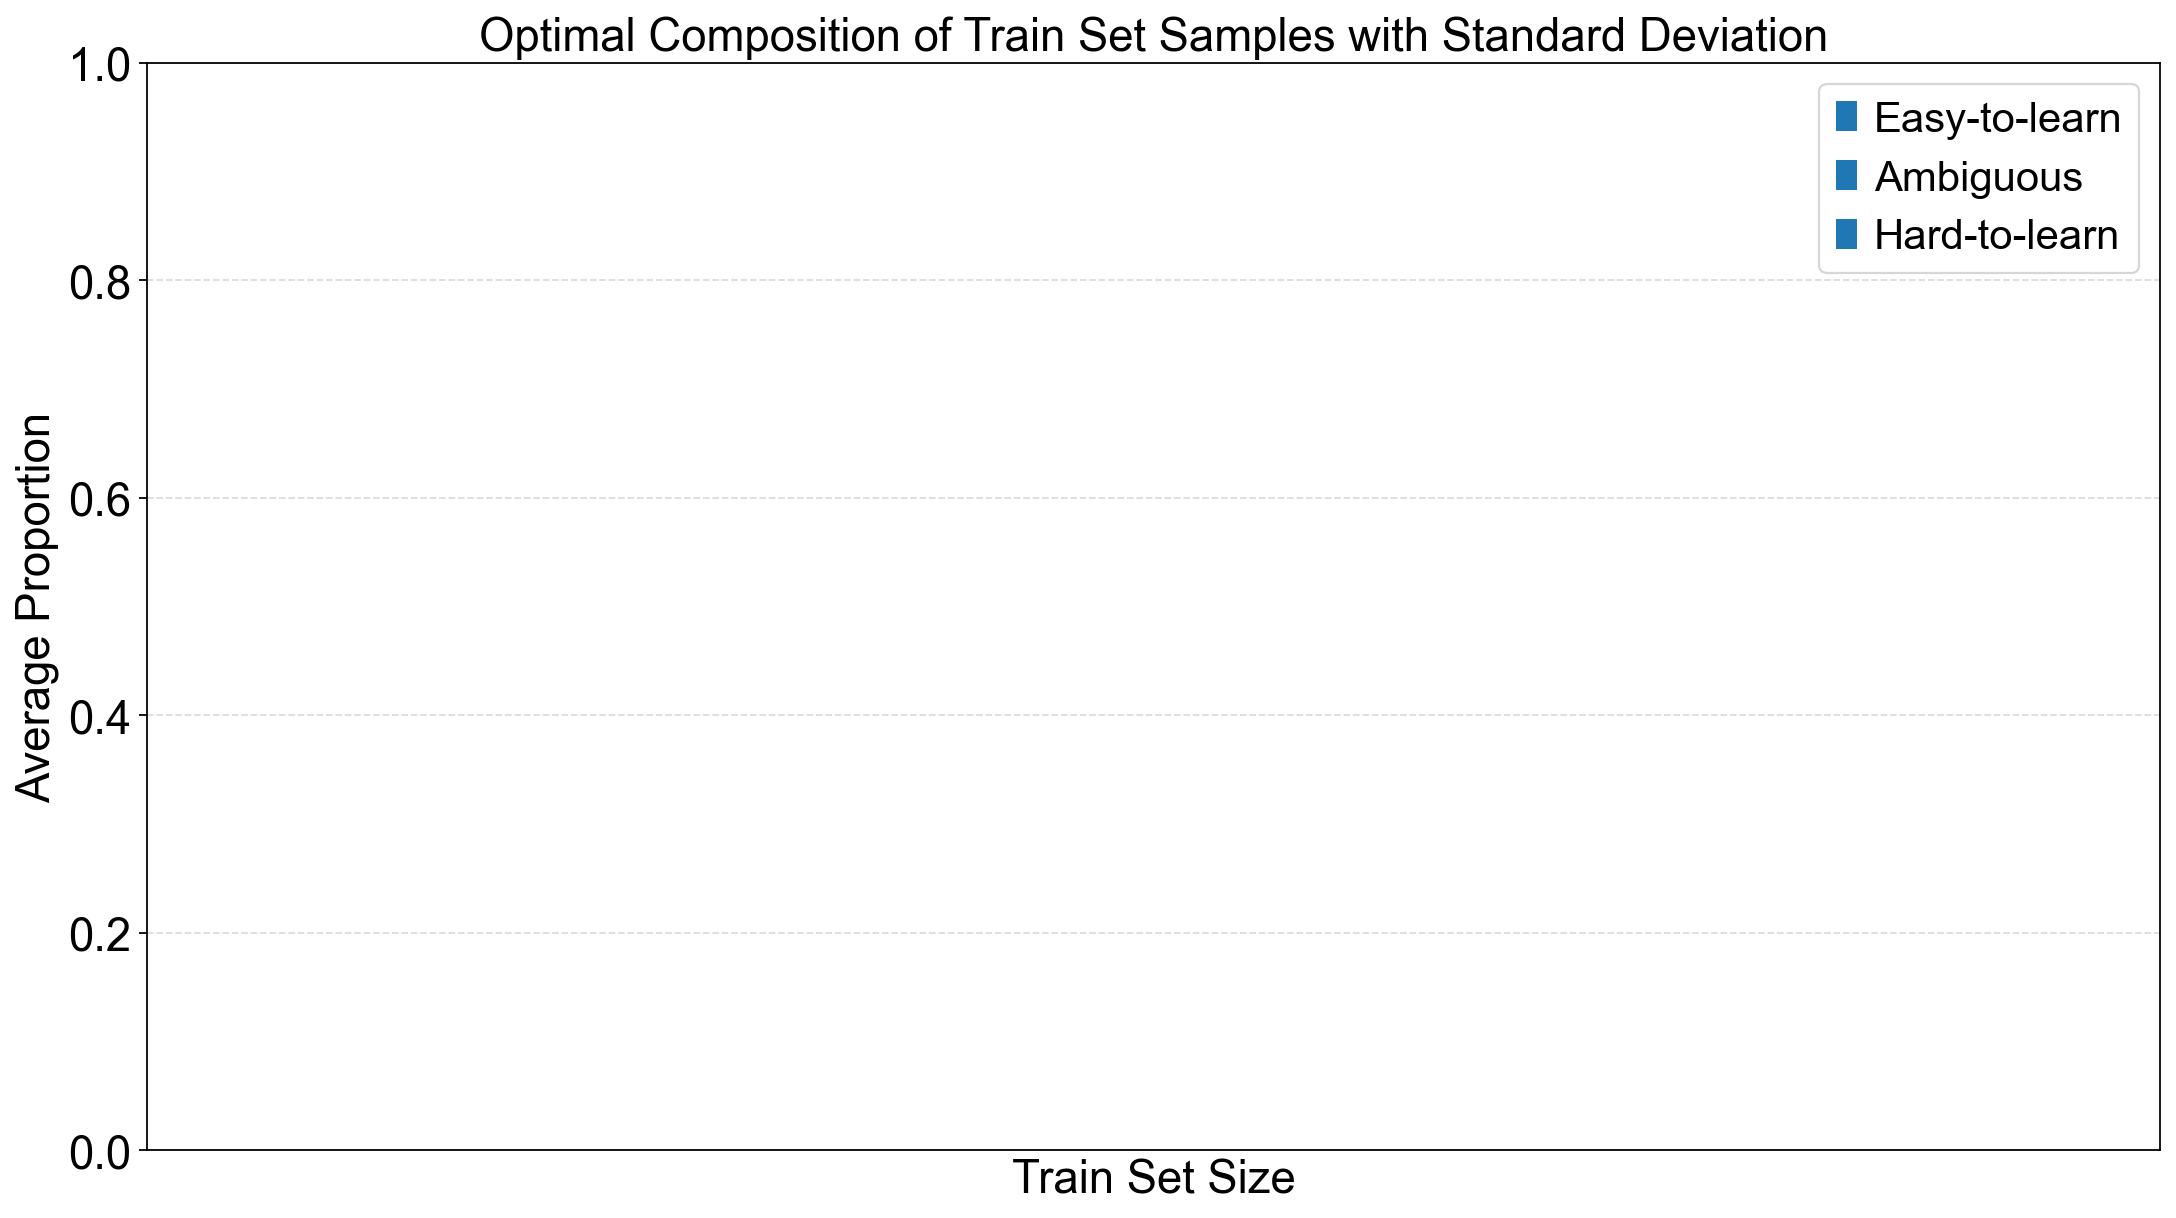

In [ ]:
# Plotting grouped bar chart with error bars (variance) without percentage labels

import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
# (Assuming 'grouped' DataFrame is already prepared in the preprocessing cell)
train_sizes = grouped['Train_Size'].values
proportion_e_mean = grouped['Proportion_Easy_mean'].values
proportion_a_mean = grouped['Proportion_Ambiguous_mean'].values
proportion_h_mean = grouped['Proportion_Hard_mean'].values
proportion_e_std = grouped['Proportion_Easy_std'].values
proportion_a_std = grouped['Proportion_Ambiguous_std'].values
proportion_h_std = grouped['Proportion_Hard_std'].values

# Set up the plot for Grouped Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.25
index = np.arange(len(train_sizes))

# Plot each category as separate bars with error bars
bars_easy = ax.bar(index - bar_width, proportion_e_mean, bar_width, yerr=proportion_e_std,
                  label='Easy-to-learn', color='green', capsize=5)
bars_ambiguous = ax.bar(index, proportion_a_mean, bar_width, yerr=proportion_a_std,
                        label='Ambiguous', color='orange', capsize=5)
bars_hard = ax.bar(index + bar_width, proportion_h_mean, bar_width, yerr=proportion_h_std,
                  label='Hard-to-learn', color='red', capsize=5)

# Customize the axes
ax.set_xticks(index)
ax.set_xticklabels([str(size) for size in train_sizes], rotation=45)
ax.set_ylabel('Average Proportion')
ax.set_xlabel('Train Set Size')
ax.set_title('Optimal Composition of Train Set Samples with Standard Deviation')
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

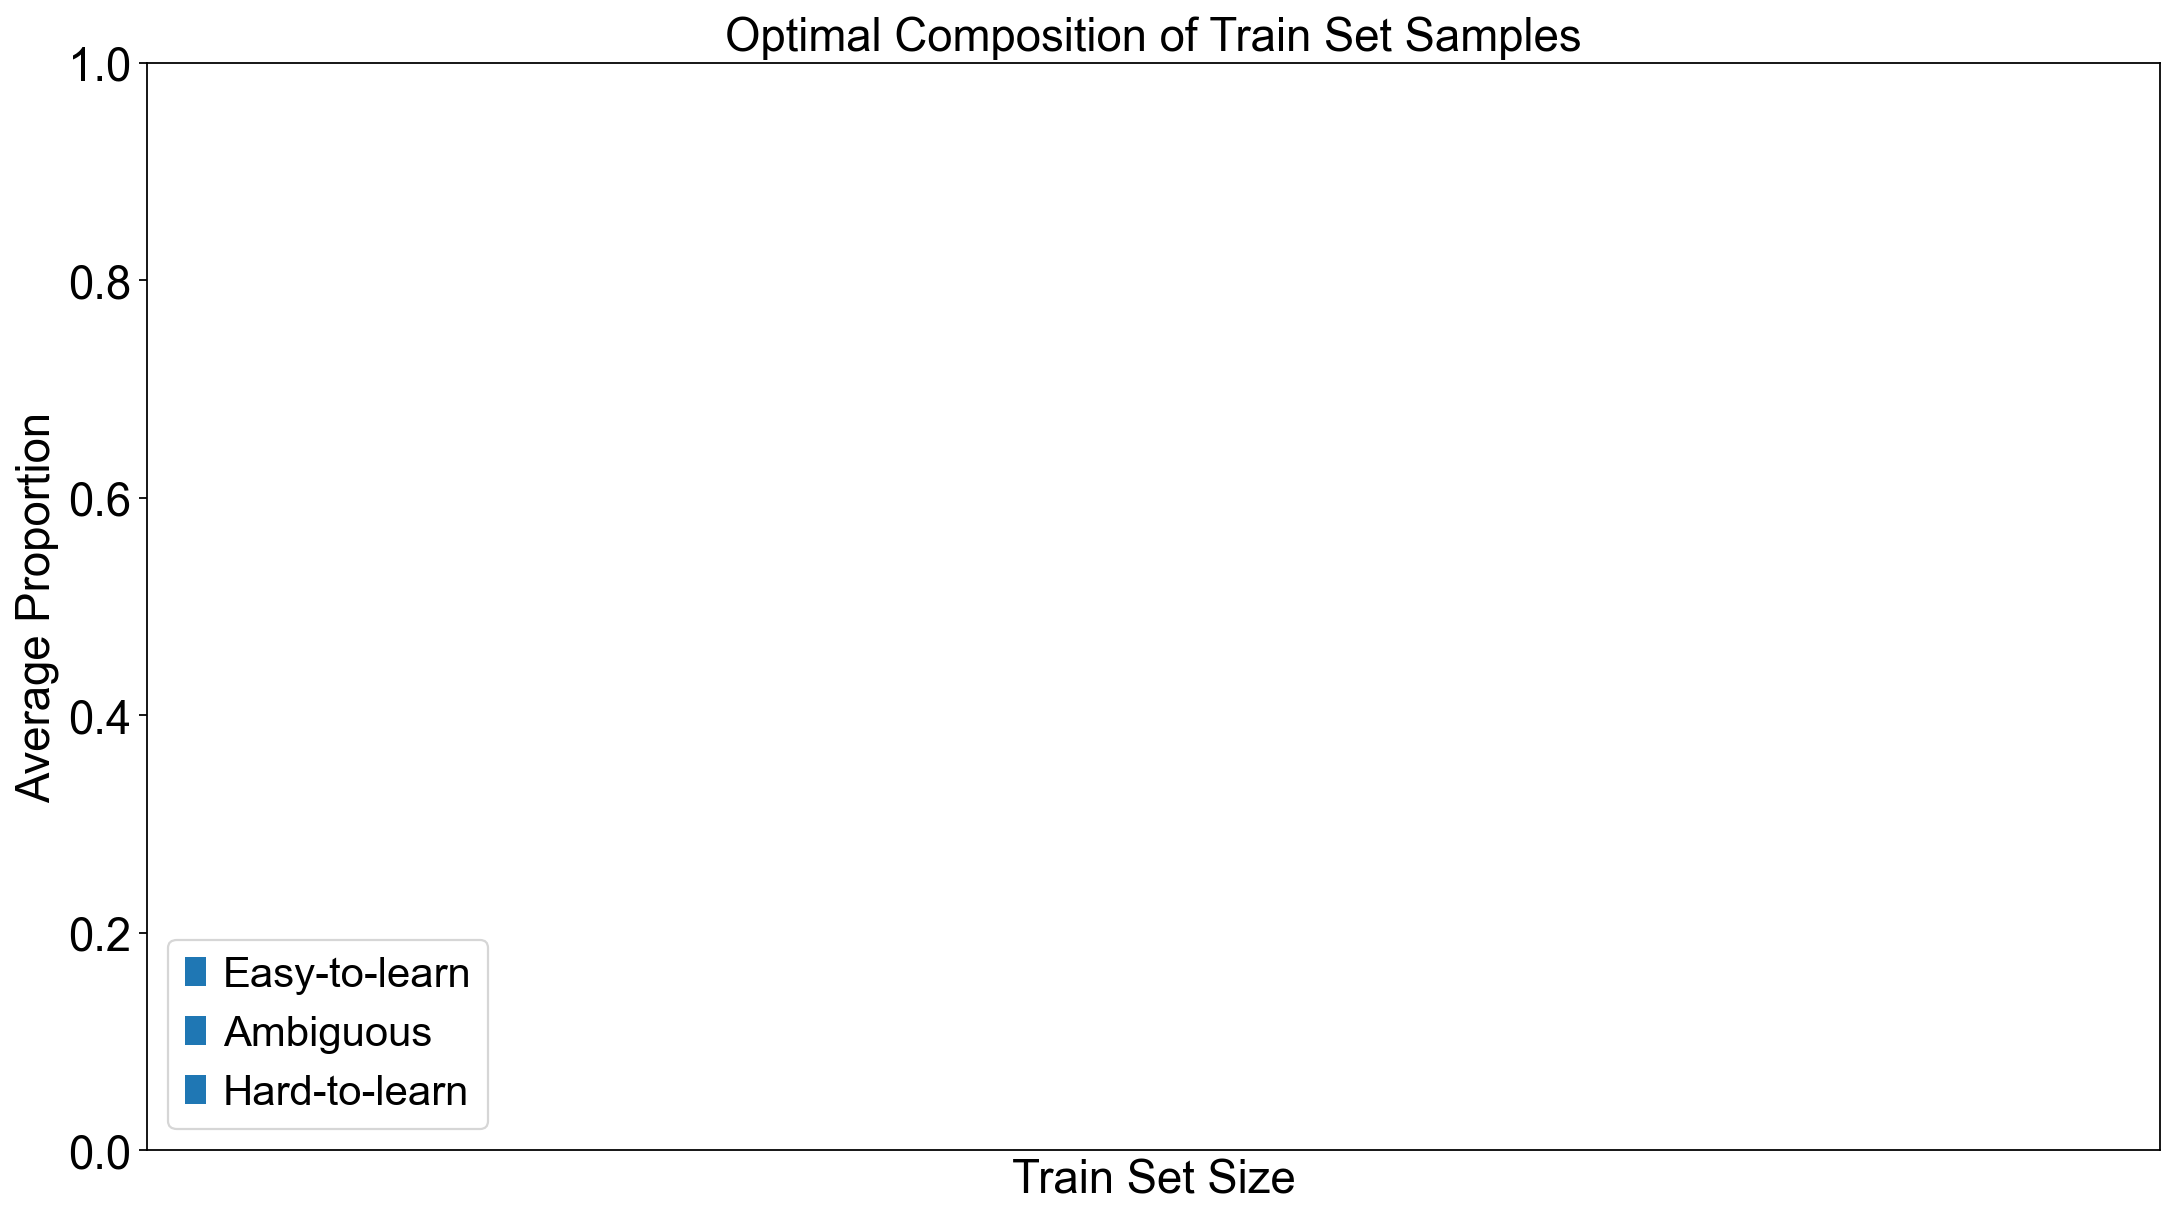

In [ ]:
# Plotting stacked bar chart without error bars but with percentage labels

import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
# (Assuming 'grouped' DataFrame is already prepared in the preprocessing cell)
# train_sizes, proportion_e_mean, proportion_a_mean, proportion_h_mean are already defined

# Set up the plot for Stacked Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.6
index = np.arange(len(train_sizes))

# Plot Easy-to-learn segment
bars_easy = ax.bar(index, proportion_e_mean, bar_width, label='Easy-to-learn', color='green')

# Plot Ambiguous segment on top of Easy-to-learn
bars_ambiguous = ax.bar(index, proportion_a_mean, bar_width, bottom=proportion_e_mean,
                        label='Ambiguous', color='orange')

# Plot Hard-to-learn segment on top of Ambiguous
bars_hard = ax.bar(index, proportion_h_mean, bar_width, bottom=proportion_e_mean + proportion_a_mean,
                  label='Hard-to-learn', color='red')

# Add percentage labels
for i in range(len(train_sizes)):
    # Easy-to-learn
    if proportion_e_mean[i] > 0.05:
        ax.text(index[i], proportion_e_mean[i]/2,
                f"{proportion_e_mean[i]*100:.1f}%", ha='center', va='center',
                color='white', fontsize=10)
    # Ambiguous
    if proportion_a_mean[i] > 0.05:
        ax.text(index[i], proportion_e_mean[i] + proportion_a_mean[i]/2,
                f"{proportion_a_mean[i]*100:.1f}%", ha='center', va='center',
                color='white', fontsize=10)
    # Hard-to-learn
    if proportion_h_mean[i] > 0.05:
        ax.text(index[i], proportion_e_mean[i] + proportion_a_mean[i] + proportion_h_mean[i]/2,
                f"{proportion_h_mean[i]*100:.1f}%", ha='center', va='center',
                color='white', fontsize=10)

# Customize the axes
ax.set_xticks(index)
ax.set_xticklabels([str(size) for size in train_sizes], rotation=45)
ax.set_ylabel('Average Proportion')
ax.set_xlabel('Train Set Size')
ax.set_title('Optimal Composition of Train Set Samples')
ax.legend(loc='lower left')
ax.set_ylim(0, 1)
ax.grid(False)

plt.tight_layout()
plt.show()

In [ ]:
# New cell to calculate compositions using top T samples with highest confidence

import pandas as pd

# Read the optimal_compositions_detailed.csv to get the test indices used previously
best_comp_df = pd.read_csv('optimal_compositions_detailed.csv')

# Initialize a new DataFrame to store the results
high_conf_df = pd.DataFrame(columns=['Train_Size', 'Train_Indices', 'Test_Indices', 'Test_Loss'])

# Sort the samples by confidence scores in descending order
# Assuming 'conf' is the column in adata_merfish.obs that contains confidence scores
sorted_conf = adata_merfish.obs.sort_values(by='conf', ascending=False)

# For each train size
for T in train_sizes:
    print(f"\nProcessing high-confidence composition for Train_Size={T}")
    
    # Get the entries for Train_Size=T to retrieve the test indices
    size_df = best_comp_df[best_comp_df['Train_Size'] == T]
    
    if size_df.empty:
        print(f"No entries found for Train_Size={T} in optimal_compositions_detailed.csv. Skipping.")
        continue
    
    # Assuming all entries for a given Train_Size use the same Test_Indices
    # Fetch unique Test_Indices for Train_Size=T
    unique_test_indices = size_df['Test_Indices'].unique()
    
    if len(unique_test_indices) != 1:
        print(f"Multiple test sets found for Train_Size={T}. Using the first one.")
    
    test_indices_str = unique_test_indices[0]
    
    if pd.isnull(test_indices_str):
        print(f"No test indices found for Train_Size={T}. Skipping.")
        continue  # Skip if no test indices
    
    test_indices = test_indices_str.split(',')
    
    # Select the top T samples with highest confidence as the training set
    # Ensure no overlap with test_indices
    top_conf_indices = sorted_conf.index.difference(test_indices)[:T].tolist()
    
    if len(top_conf_indices) < T:
        print(f"Not enough available samples to select top {T} without overlapping with test set.")
        print(f"Available samples: {len(top_conf_indices)}")
        continue  # Skip if not enough samples
    
    # Create training and testing datasets
    adata_train = adata_merfish[top_conf_indices].copy()
    adata_test = adata_merfish[test_indices].copy()
    
    # Train and get test loss
    test_loss = train_and_evaluate_model(
        adata_train, adata_test, label_key='CellType', label_encoder=global_label_encoder,
        epoch_num=30, device=device, batch_size=64
    )
    
    # Save the result
    high_conf_df = high_conf_df.append({
        'Train_Size': T,
        'Train_Indices': ','.join(map(str, top_conf_indices)),
        'Test_Indices': ','.join(map(str, test_indices)),
        'Test_Loss': test_loss
    }, ignore_index=True)
    
    print(f"Train_Size={T}, Test Loss={test_loss}")

# Save the results to a new CSV file
high_conf_df.to_csv('high_confidence_compositions.csv', index=False)

print("\nHigh-confidence compositions have been saved to 'high_confidence_compositions.csv'.")

In [ ]:
# Read the results from the CSV files
optimal_comp_df = pd.read_csv('optimal_compositions_detailed.csv')
high_conf_df = pd.read_csv('high_confidence_compositions.csv')

# Calculate the average test loss for each Train_Size in the optimal compositions
optimal_loss_df = optimal_comp_df.groupby('Train_Size')['Test_Loss'].mean().reset_index()
optimal_loss_df.rename(columns={'Test_Loss': 'Optimal_Test_Loss'}, inplace=True)

# Prepare the test loss for the high confidence compositions
high_conf_loss_df = high_conf_df[['Train_Size', 'Test_Loss']]
high_conf_loss_df.rename(columns={'Test_Loss': 'High_Conf_Test_Loss'}, inplace=True)

# Merge the two DataFrames on 'Train_Size'
comparison_df = pd.merge(optimal_loss_df, high_conf_loss_df, on='Train_Size')

# Sort by Train_Size
comparison_df.sort_values('Train_Size', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Train_Size'], comparison_df['Optimal_Test_Loss'], marker='o', label='Optimal Composition')
plt.plot(comparison_df['Train_Size'], comparison_df['High_Conf_Test_Loss'], marker='s', label='High Confidence Composition')

plt.title('Comparison of Test Losses by Train Size')
plt.xlabel('Train Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()